In [56]:
import numpy as np
import matplotlib.pylab as plt
np.random.seed(10)

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()
  

In [57]:
def minmax_cuts(X, y):
    # print(X.shape)
    min_col = -5
    max_col = 5
    min_mag = 12
    max_mag = 25
    min_z = 0.0
    max_z = 1.25
    
    mask_cond =  np.where( 
        (X[:, 0] < max_col) & (X[:, 0] > min_col) &
        (X[:, 1] < max_col) & (X[:, 1] > min_col) &
        (X[:, 2] < max_col) & (X[:, 2] > min_col) &
        (X[:, 3] < max_col) & (X[:, 3] > min_col) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    
    # print( np.array(mask_cond).shape)

    X_new = X[mask_cond]
    y_new = y[mask_cond]
    # print(X_new.shape)
    return X_new, y_new

In [58]:
def rescale(X, y):
    # xmin = np.array([-5, -5, -5, -5, 12])
    # xmax =  np.array([5, 5, 5, 5, 25])
    # ymin = 0.0
    # ymax = 1.25

    X_new = (X - xmin)/(xmax - xmin)
    y_new = (y - ymin)/(ymax - ymin)
    return X_new, y_new 

In [59]:
def print_limits(X, y):
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0))
    print('ColMag-max: ', np.max(X, axis=0))

In [60]:
def shuffle(X, y):
    np.random.seed(12211)  
    shuffleOrder = np.arange(X.shape[0])
    np.random.shuffle(shuffleOrder)
    X = X[shuffleOrder]
    y = y[shuffleOrder]
    return X, y

In [61]:

def ReadFSPS_raw(path_program = '../../Data/fromGalaxev/photozs/datasets/'):
    
    fsps_ip = np.load('../../Data/fromGalaxev/photozs/datasets/data_apr_2020/fsps_sdss_join_col_mag.npy')
    # (ngal, nprop, nredshift, ncol)
    ngal, nprop, nz, ncol = fsps_ip.shape
    fsps_reshaped = fsps_ip.reshape(-1, nz, ncol)
    fsps_reshaped = fsps_reshaped.reshape(-1, ncol)

    fsps_ip_z= np.load('../../Data/fromGalaxev/photozs/datasets/data_apr_2020/fsps_sdss_join_zz.npy')
    ngal, nprop, nz = fsps_ip_z.shape
    fsps_z_reshaped = fsps_ip_z.reshape(-1, nz)
    fsps_z_reshaped = fsps_z_reshaped.reshape(-1)

    fsps_ip_flag = np.load('../../Data/fromGalaxev/photozs/datasets/data_apr_2020/fsps_sdss_join_flag_zz.npy')
    ngal, nprop, nz = fsps_ip_flag.shape
    fsps_flag_reshaped = fsps_ip_flag.reshape(-1, nz)
    fsps_flag_reshaped = fsps_flag_reshaped.reshape(-1)

    if Trainset == 'FSPSlin':
        z_index = (fsps_flag_reshaped == 0)
    elif Trainset == 'FSPSlog':
        z_index = (fsps_flag_reshaped == 1)
    elif Trainset == 'FSPSall':
        z_index = (fsps_flag_reshaped != 2)
    else: 
        z_index = (fsps_flag_reshaped != 3)

    Trainfiles = np.append(fsps_z_reshaped[z_index][:, None], fsps_reshaped[z_index], axis=1) 

    X_FSPS = Trainfiles[:, 1:]  # color mag
    y_FSPS = Trainfiles[:, 0]  # spec z

    ##################################################
   
    TestOBS = True
    if TestOBS:

        fileIn_col = path_program + 'data_apr_2020/obs_cols.npy'
        fileIn_z = path_program + 'data_apr_2020/obs_zz.npy'
        

        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z)
        
        Testfiles = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)

        X_OBS = Testfiles[:, 1:]  # color mag
        y_OBS = Testfiles[:, 0] # spec z
    

    ############################################################

    print('OBS')
    print_limits(X_OBS, y_OBS)

    
    ##### min-max cuts #####

    # X_FSPS, y_FSPS = minmax_cuts(X_FSPS, y_FSPS)
    X_OBS, y_OBS = minmax_cuts(X_OBS, y_OBS)

    print('FSPS')
    print_limits(X_FSPS, y_FSPS)
    print('OBS')
    print_limits(X_OBS, y_OBS)

    ##### shuffle #####

    X_FSPS, y_FSPS = shuffle(X_FSPS, y_FSPS)
    X_OBS, y_OBS = shuffle(X_OBS, y_OBS)

    return X_FSPS, y_FSPS, X_OBS, y_OBS

In [62]:
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS'][0]
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS'][3]

In [63]:
X_FSPS, y_FSPS, X_OBS, y_OBS = ReadFSPS_raw(path_program = '../../Data/fromGalaxev/photozs/datasets/')

OBS
number of datapoints:  271860
z-minmax:  5.843881822897856e-08 7.011244773864746
ColMag-min:  [-16.02178146  -8.86878939  -1.98356056 -16.55613166  11.09888744]
ColMag-max:  [17.02883987 20.22452066  8.5757395   2.73801613 22.99328526]
FSPS
number of datapoints:  17709557
z-minmax:  0.002000010024108306 1.2499997501080744
ColMag-min:  [-0.1784067  -0.58599727 -1.46125335 -1.77934106  5.55541849]
ColMag-max:  [  3.79654048   3.23352432   1.89477147   2.41539175 102.21784816]
OBS
number of datapoints:  271050
z-minmax:  5.843881822897856e-08 1.246999979019165
ColMag-min:  [-4.25878525 -3.89014053 -1.98356056 -4.82941818 12.01159477]
ColMag-max:  [ 4.99607277  4.97422409  4.18241501  2.73801613 22.99328526]


In [64]:
xmin = np.array([-5, -5, -5, -5, 12])
xmax =  np.array([5, 5, 5, 5, 25])
ymin = 0.0
ymax = 1.0 #1.25

rescaleTrue = True
if rescaleTrue:
    
    X_FSPS, y_FSPS = rescale(X_FSPS, y_FSPS)
    X_OBS, y_OBS = rescale(X_OBS, y_OBS)


In [65]:
num_train = 30000000 #15000000
num_test = 20000

In [66]:
# num_train = 250000 #15000000
# num_test = 20000

In [67]:
if (Trainset != Testset):
    if Trainset == 'FSPSlin':
        Trainz_sample = 'Linear'
        X_train = X_FSPS[: num_train, :]
        y_train = y_FSPS[: num_train]
        
    if Trainset == 'FSPSlog':
        Trainz_sample = 'Log'
        X_train = X_FSPS[: num_train, :]
        y_train = y_FSPS[: num_train]

    if Trainset == 'FSPSall':
        Trainz_sample = 'All'
        X_train = X_FSPS[: num_train, :]
        y_train = y_FSPS[: num_train]


    if Testset == 'OBS':
        X_test = X_OBS[: num_test, :]
        y_test = y_OBS[: num_test]



In [68]:
if (Trainset == Testset):
        
    if Testset == 'OBS':
        X_train = X_OBS[: num_train, :]
        y_train = y_OBS[: num_train]

        X_test = X_OBS[num_train+1: num_train + num_test + 1, :]
        y_test = y_OBS[num_train+1: num_train + num_test + 1]


In [69]:

print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (17709557, 5)
Size of output in training data: (17709557,)
Size of features in test data: (20000, 5)
Size of output in test data: (20000,)


In [70]:
# ## BEST ONE SO FAR - fsps train sdss test ###
# n_epochs = 12
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3  #16 # number of mixture components

# learning_rate = 1e-2
# decay_rate= 1e-2
# step=4#100
# batch_size = 8 #8192 # 1024 #8192

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [71]:
# ## BEST ONE SO FAR - fsps train all test ###
# n_epochs = 32
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3  #16 # number of mixture components

# learning_rate = 1e-1
# decay_rate= 1e-2
# step=1#100
# batch_size = 8192 #8192 # 1024 #8192

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [72]:
## BEST ONE SO FAR - fsps-lin train obs test ###
n_epochs = 8
D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
K = 3 #16 # number of mixture components

learning_rate = 1e-1
decay_rate= 1e-2
step=1#100
batch_size = 65536 #32768 #16384 #8192 # 1024 #8192

save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [73]:
# ## BEST ONE SO FAR - fsps-log train obs test ###
# n_epochs = 16
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 2  #16 # number of mixture components

# learning_rate = 1e-2
# decay_rate= 1e-2
# step=1#100
# batch_size = 50000 #32768 #16384 #8192 # 1024 #8192

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [74]:
# ## BEST ONE SO FAR - obs train obs test ###
# n_epochs = 128
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 2  #16 # number of mixture components

# learning_rate = 1e-2
# decay_rate= 1e-3
# step=4#100
# batch_size = 64 #1024 #8192 #50000 #32768 #16384 #8192 # 

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

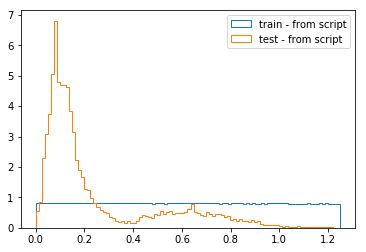

In [75]:
plt.figure(23)
# y_t = 10**(ymax - ymin)*(ymin + y_test)
y_t =  y_test
y_tr =  y_train

plt.hist(y_tr, normed=True, bins = 100, histtype='step', label='train - from script')
plt.hist(y_t, normed=True, bins = 100, histtype='step', label='test - from script')
plt.legend()

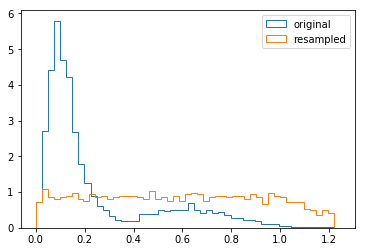

In [76]:
reSampleTest = True
if reSampleTest :
    # test_argsort = np.argsort(y_test)
    # y_test = y_test[test_argsort]
    # X_test = X_test[test_argsort]

    num_y_test_select_per_bin = 10
    n_bins = 100
    np.random.seed(1)

    bins = np.linspace(y_test.min(), y_test.max(), n_bins)
    # bins = np.logspace(np.log10(y_test.min()+1e-2), np.log10(y_test.max()+1e-2), n_bins)
    inds = np.digitize(y_test, bins)

    # print(bins)
    # print(inds.shape, inds.max())
    # hist_y = np.histogram(y_test, bins = bins)
    # plt.plot(inds)
    # plt.plot(hist_y[0], '-.')
    # plt.yscale('log')

    resampled_ind = []

    for ind_i in range(n_bins):
        ind_bin = np.where(inds==ind_i)
        random_choices = np.min( [num_y_test_select_per_bin, np.size(ind_bin) ])
        index = np.random.choice(ind_bin[0], random_choices, replace=False)
        resampled_ind = np.append(resampled_ind, index)

    resampled_ind = resampled_ind.astype('int')


    plt.figure(23)
    plt.hist(y_test, normed=True, bins = 50, histtype='step', label='original')
    y_test1 = y_test[resampled_ind]
    X_test1 = X_test[resampled_ind]

    plt.hist(y_test1, normed=True, bins = 50, histtype='step', label='resampled')
    plt.legend()
    plt.show()

    # print(int_select)




In [77]:
if reSampleTest :
    y_test = y_test1
    X_test = X_test1

In [78]:
PairPlotTrue = False

if PairPlotTrue:
    import seaborn as sns
    import pandas as pd
    from IPython.display import Image

    ############ loading data ############
    # num_train = 800000

    # _, _, X_test, y_test, ymax, ymin, xmax, xmin = ReadGalaxPy(path_program = '../../../Data/fromGalaxev/photozs/datasets/', sim_obs_combine = False)

    # print("Size of features in training data: {}".format(X_train.shape))
    # print("Size of output in training data: {}".format(y_train.shape))
    # print("Size of features in test data: {}".format(X_test.shape))
    # print("Size of output in test data: {}".format(y_test.shape))

    num_data = 2000

    df_train = pd.DataFrame()

    # Add columns
    df_train['u-g'] = X_train[:num_data, 0]
    df_train['g-r'] = X_train[:num_data, 1]
    df_train['r-i'] = X_train[:num_data, 2]
    df_train['i-z'] = X_train[:num_data, 3]
    df_train['mag(i)'] = X_train[:num_data, 4]
    df_train['redshift'] = y_train[:num_data]


    df_test = pd.DataFrame()

    # Add columns
    df_test['u-g'] = X_test[:num_data, 0]
    df_test['g-r'] = X_test[:num_data, 1]
    df_test['r-i'] = X_test[:num_data, 2]
    df_test['i-z'] = X_test[:num_data, 3]
    df_test['mag(i)'] = X_test[:num_data, 4]
    df_test['redshift'] = y_test[:num_data]


    df_all = pd.concat([df_train.assign(dataset='train'), df_test.assign(dataset='test')])


    #### plotting ####
    g = sns.PairGrid(df_all, hue='dataset')
    g = g.map_upper(sns.scatterplot, alpha=0.5)
    g = g.map_lower(sns.kdeplot, n_levels=6, shade=True, shade_lowest=False, alpha=0.7)
    g = g.map_diag(sns.kdeplot, lw=2, shade=True)
    # g = g.map_diag(sns.distplot, hist=True, kde=False)
    g = g.add_legend()

    g.savefig("pairplot_sdss_deep.png")

    plt.clf() # Clean parirplot figure from sns 
    Image(filename='pairplot_sdss_deep.png') # Show pairplot as image

    # plt.show()

In [79]:
output_shape = 1 

model_train = keras.Sequential([
    keras.layers.Dense(units=256, activation='relu', input_shape=(D,)),
    keras.layers.Dense(units=1024, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(tfp.layers.MixtureNormal.params_size(K, output_shape)),
    tfp.layers.MixtureNormal(K, output_shape)])

# model_train = keras.Sequential([
#     keras.layers.Dense(units=32, activation='relu', input_shape=(D,)),
#     keras.layers.Dense(units=16, activation='relu'),
#     keras.layers.Dense(units=8, activation='relu'),
#     keras.layers.Dense(units=4, activation='relu'),
#     keras.layers.Dense(tfp.layers.MixtureNormal.params_size(K, output_shape)),
#     tfp.layers.MixtureNormal(K, output_shape)])



# model = keras.Sequential([
#     keras.layers.Dense(units=32, activation='relu', input_shape=(D,)),
#     keras.layers.Dense(units=16, activation='tanh'),
#     keras.layers.Dense(units=8, activation='tanh'),
#     # keras.layers.Dense(tfp.layers.MixtureNormal.params_size(K, output_shape)),
#     # tfp.layers.MixtureNormal(K, output_shape)
#     keras.layers.Dense(units=K*3),
#     tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#         tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
#                 logits=tf.expand_dims(t[..., :K], -2)),
#                 components_distribution=tfd.Beta(1 + tf.nn.softplus(tf.expand_dims(t[..., K:2*K], -2)), 
#                 1 + tf.nn.softplus(tf.expand_dims(t[..., 2*K:],-2)))), 1))])


def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)


# callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)

# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1= decay_rate, amsgrad = True)
# model.compile(loss=negloglik, optimizer=opt, metrics=[])



callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)
checkpoint = ModelCheckpoint(save_mod + '.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint,callback,earlystopping]


opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1= decay_rate, amsgrad = True)
model_train.compile(loss=negloglik, optimizer=opt, metrics=[])
model_train.summary()

model = model_train

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               1536      
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 16)               

Train on 17709557 samples, validate on 913 samples
Epoch 1/5
17709557/17709557 - 564s - loss: 0.1766 - val_loss: -3.8093e-01
Epoch 2/5
17709557/17709557 - 521s - loss: -7.5683e-02 - val_loss: -3.7825e-01
Epoch 3/5
17709557/17709557 - 520s - loss: -2.0349e-01 - val_loss: -1.6968e-01
Epoch 4/5
17709557/17709557 - 543s - loss: -2.4771e-01 - val_loss: 0.1345
Epoch 5/5
17709557/17709557 - 522s - loss: -4.6081e-01 - val_loss: -5.2208e-01


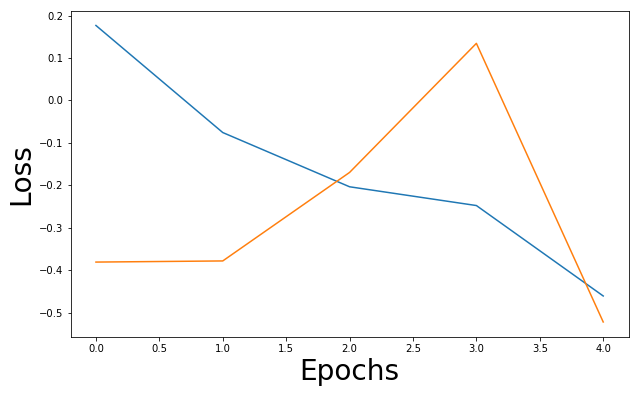

In [25]:
train_mode = True

if train_mode:

    history = model_train.fit(X_train, y_train,  validation_data=(X_test, y_test), epochs=n_epochs, batch_size=batch_size, callbacks=[callback], verbose=2)
    # history = model_train.fit(X_train, y_train, validation_split=0.2, epochs=n_epochs, batch_size=batch_size, callbacks=[callback], verbose=2)

    model_train.save(save_mod + '.h5')
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs', fontsize = 28)
    plt.ylabel('Loss', fontsize = 28)

In [26]:
# model_train.save(save_mod + '.h5')
model.load_weights(save_mod + '.h5')

y_pred = model(X_test)
y_pred_mean = y_pred.components_distribution.mean() 
y_pred_std = y_pred.components_distribution.stddev()
y_pred_mode = y_pred.components_distribution.mode() 

In [27]:
y_pred_mean[:, :, 0].shape

TensorShape([913, 3])

In [28]:
y_pred_std[:, :, 0].shape

TensorShape([913, 3])

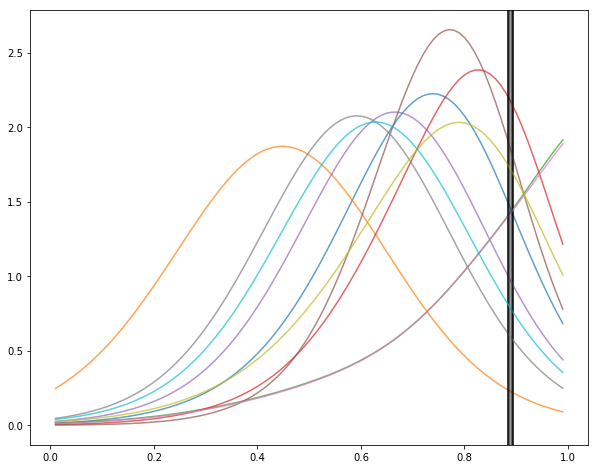

In [29]:
y_arr = np.arange(0.01, 1, 0.01)
# print(y_arr)
log_p = []
for y_arr_val in y_arr:
    log_p.append(y_pred.log_prob(y_arr_val).numpy())


plt.figure(143, figsize=((10,8)))
for galID in range(700, 710):
    plt.plot(y_arr, np.exp(np.array(log_p).T[galID]), alpha = 0.7);
    plt.axvline(x=y_test[galID], color='black', alpha=0.5);
# plt.savefig('exp_log_p.png')
plt.show()


In [30]:
y_pred.components_distribution.mode()

<tf.Tensor: id=13540, shape=(913, 3, 1), dtype=float32, numpy=
array([[[0.06686134],
        [0.14391357],
        [0.1010759 ]],

       [[0.06364654],
        [0.14821884],
        [0.10880236]],

       [[0.06728701],
        [0.14404902],
        [0.08849704]],

       ...,

       [[1.1474484 ],
        [0.85562783],
        [1.0465938 ]],

       [[0.4598076 ],
        [0.45885223],
        [0.40894565]],

       [[1.0514303 ],
        [0.78193355],
        [0.9267212 ]]], dtype=float32)>

In [31]:
y_pred.components_distribution.distribution.mean()

<tf.Tensor: id=13545, shape=(913, 3, 1), dtype=float32, numpy=
array([[[0.06686134],
        [0.14391357],
        [0.1010759 ]],

       [[0.06364654],
        [0.14821884],
        [0.10880236]],

       [[0.06728701],
        [0.14404902],
        [0.08849704]],

       ...,

       [[1.1474484 ],
        [0.85562783],
        [1.0465938 ]],

       [[0.4598076 ],
        [0.45885223],
        [0.40894565]],

       [[1.0514303 ],
        [0.78193355],
        [0.9267212 ]]], dtype=float32)>

In [32]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', color = '', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """

  x = np.linspace(-0.1, 1.1, 250)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
#       ax.plot(x, temp, label='Normal ' + str(i), alpha =0.6)
      ax.plot(x, temp, 'k--', alpha =0.9)

#       ax.plot(x, temp/final.max(), alpha =0.5)

  ax.plot(x, final,label=label, color = color)
#   ax.plot(x, final/final.max(), label=label, color = color)

    
  ax.legend(fontsize=13)
  return final

def plot_pdfs(pred_means,pred_weights,pred_std, y,num=4, label = '', color = '', train=False, comp = False):
    np.random.seed(12)

    if train:
        obj = np.random.randint(0,num_train-1,num)
    else:
        obj = np.random.randint(0,num_test-1,num)
#     obj = [462, 667, 81]
    obj = [420, 102, 81]
    # obj = [4, 18, 81]
    
    print(obj)

    allfs = []
    for i in range(len(obj)):
        print(i)
        if (i==0):
            fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i], pred_std[obj][i], axes[i], label = label, color = color, comp=comp)
        else: fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i], pred_std[obj][i], axes[i], label = '', color = color, comp=comp)

        axes[i].set_ylabel(r'${\rm PDF}$', fontsize = 22)
        allfs.append(fs)
        axes[i].axvline(x=y[obj][i], color='black', alpha=0.5)
        

    plt.xlabel('Photometric redshift', fontsize = 26)
    


No handles with labels found to put in legend.
No handles with labels found to put in legend.
[420, 102, 81]
0
1
2


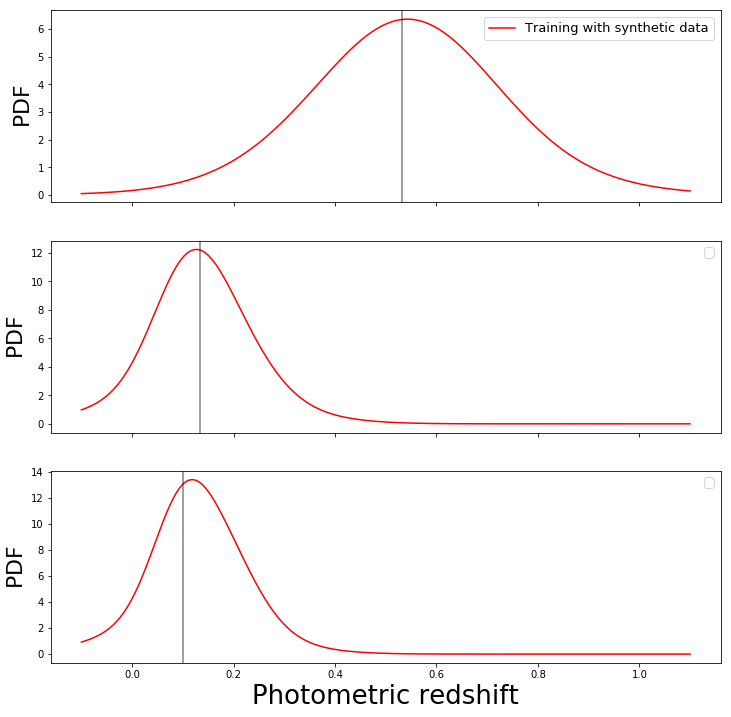

In [33]:
test_means = np.array(y_pred_mean[:, :, 0] )
test_std = np.array(y_pred_std[:, :, 0] )
test_weights = np.ones_like(test_means)

## plotting pdfs
from scipy import stats

nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(12, nrows*4), num='pdfs')
plot_pdfs(test_means,test_weights,test_std, y_test, num=nrows, label = 'Training with synthetic data', color = 'red', train=False)
# plot_pdfs(test_means_2,test_weights_2,test_std_2, y_test, num=nrows, label = 'Training with observational data', color = 'blue', train=False)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
[420, 102, 81]
0
1
2


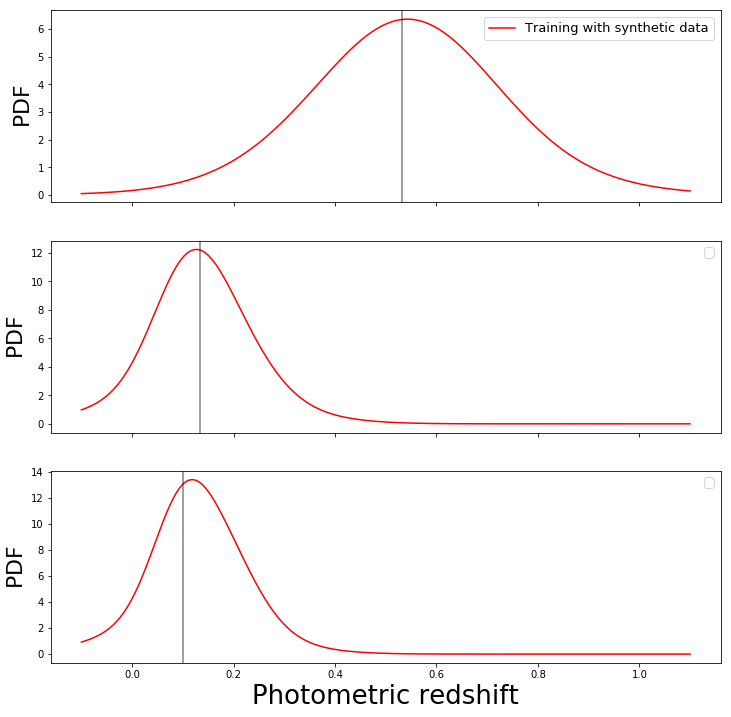

In [34]:
test_means = np.array(y_pred_mean[:, :, 0] )
test_std = np.array(y_pred_std[:, :, 0] )
test_weights = np.ones_like(test_means)

## plotting pdfs

from scipy import stats

nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(12, nrows*4), num='pdfs')
plot_pdfs(test_means,test_weights,test_std, y_test, num=nrows, label = 'Training with synthetic data', color = 'red', train=False)
# plot_pdfs(test_means_2,test_weights_2,test_std_2, y_test, num=nrows, label = 'Training with observational data', color = 'blue', train=False)

No handles with labels found to put in legend.


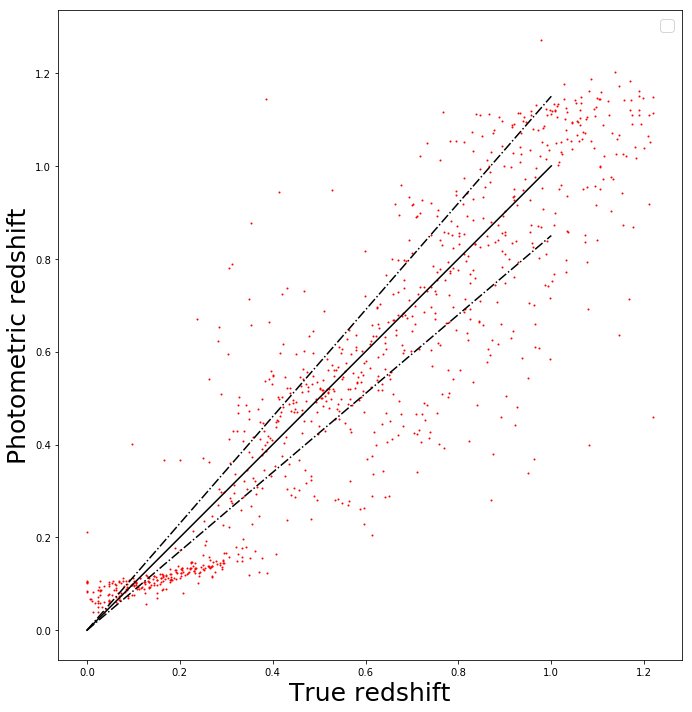

In [35]:
# fig = plt.figure(22)

ifPlotWeighted = True
# y_pred_mean_best = y_pred_mean[:, 0]
y_pred_mean_best = y_pred_mode[:, 0]
y_pred_std_best = y_pred_std[:, 0]


if ifPlotWeighted:
    plt.figure(22, figsize=(10, 10,))
    # plt.scatter((ymax - ymin)*(ymin + y_test),(ymax - ymin)*(ymin + y_pred_mean_best), facecolors='r', s = 1)
    plt.scatter(y_test,y_pred_mean_best, facecolors='r', s = 1)


# plt.xlim(0.0, 1)
# plt.ylim(0.0, 1)
plotlims = [0, 1] #[ymin, ymax]
# plotlims = [ymin, ymax]
plt.plot(plotlims, plotlims, 'k')
plt.plot(plotlims, 0.85*np.array(plotlims), 'k-.')
plt.plot(plotlims, 1.15*np.array(plotlims), 'k-.')

# plt.ylabel(r'$z_{\rm phot}$', fontsize=30)
# plt.xlabel(r'$z_{\rm spec}$', fontsize=30)
plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)


# plt.legend(fontsize = 'large', markerscale=3., numpoints=3)
# plt.title('weight x mean')
plt.tight_layout()

plt.axes().set_aspect('equal')

# plt.xscale('log')
# plt.yscale('log')

leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.savefig('phoz_compare.pdf', bbox_inches='tight')

plt.show()


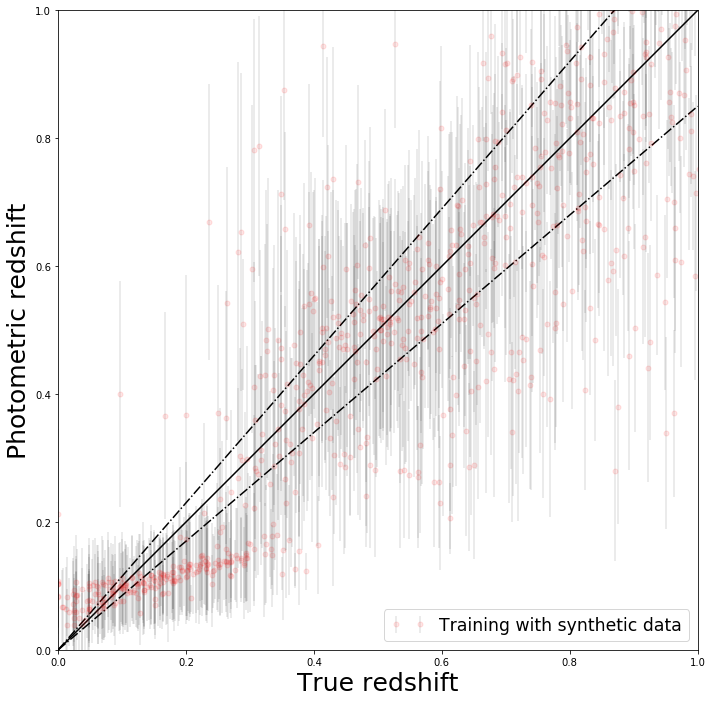

In [36]:
# fig = plt.figure(22)

ifPlotWeighted = True
# y_pred_mean_best = y_pred_mean[:, 0]
y_pred_mean_best = y_pred_mode[:, 0]
y_pred_std_best = y_pred_std[:, 0]

## Overall mean --- weight * mean
ifPlotWeighted = True

if ifPlotWeighted:
    plt.figure(22, figsize=(10, 10))

#     y_pred = np.sum(pred_means_new*pred_weights_new, axis = 1)
#     y_pred_std_new = np.sum(pred_std_new*pred_weights_new, axis = 1)

    # # plt.scatter(y_test, y_pred, facecolors='k', s = 1)
#     plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
#       ymin + y_pred_std_new), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)
    
    plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred_mean_best), yerr= (ymax - ymin)*(
      ymin + y_pred_std_best ), fmt='ro', ecolor='k', ms = 5, alpha = 0.1, label = 'Training with synthetic data')

#     plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
#       ymin + y_pred_std), fmt='wo', ecolor='w', ms = 5, alpha = 0.8, label = 'Training with synthetic data')



    # plt.text(0.8, 2.0, datafile, horizontalalignment='center', verticalalignment='center')
    # plt.ylabel(r'$z_{pred}$', fontsize = 19)
    # plt.xlabel(r'$z_{true}$', fontsize = 19)

    # plt.title('weight x mean')
    # plt.tight_layout()
    # plt.show()



## Overall mean --- weight * mean
# ifPlotWeighted = True


# if ifPlotWeighted:

# #     y_pred_new2 = np.sum(pred_means_new2*pred_weights_new2, axis = 1)
# #     y_pred_std_new2 = np.sum(pred_std_new2*pred_weights_new2, axis = 1)

# #     plt.figure(22, figsize=(6,6))


#     # plt.scatter(y_test2, y_pred, facecolors='k', s = 1)
# #     plt.errorbar((ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred), yerr= (ymax2 - ymin2)*(
# #       ymin2 + y_pred_std_new2), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)
    
#     plt.errorbar((ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred_2), yerr= (ymax2 - ymin2)*(
#       ymin2 + y_pred_std_2), fmt='bo', ecolor='b', ms = 5, alpha = 0.3, label = 'Training with observational data')

# #     plt.errorbar((ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred_2), yerr= (ymax2 - ymin2)*(
# #       ymin2 + y_pred_std_2), fmt='co', ecolor='c', ms = 5, alpha = 0.8, label = 'Training with observational data')



#     # plt.text(0.8, 2.0, datafile, horizontalalignment='center', verticalalignment='center')

# plt.xlim(0, 1)
# plt.ylim(0, 1)

# # plt.text(0.1, 0.9, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_obs_all, color = 'red' , size = 20)
# # plt.text(0.1, 0.85, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_combine_all, color = 'blue' , size = 20)
# plt.text(0.6, 0.2, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_obs_all, color = 'blue' , size = 20)
# plt.text(0.6, 0.1, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_combine_all, color = 'red' , size = 20)

# plt.text(0.1, 0.9, r'GalaxPy training', color = 'red' , size = 20)
# plt.text(0.1, 0.85, r'SDSS training', color = 'blue' , size = 20)

plt.plot([0, 1], [0, 1], 'k')
plt.plot([0, 1], 0.85*np.array([0, 1]), 'k-.')
plt.plot([0, 1], 1.15*np.array([0, 1]), 'k-.')

# plt.ylabel(r'$z_{\rm phot}$', fontsize=30)
# plt.xlabel(r'$z_{\rm spec}$', fontsize=30)


plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)

# plt.legend(fontsize = 'large', markerscale=3., numpoints=3)
# plt.title('weight x mean')
plt.tight_layout()

plt.axes().set_aspect('equal')

# plt.xscale('log')
# plt.yscale('log')

leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.savefig('phoz_compare.pdf', bbox_inches='tight')

plt.show()


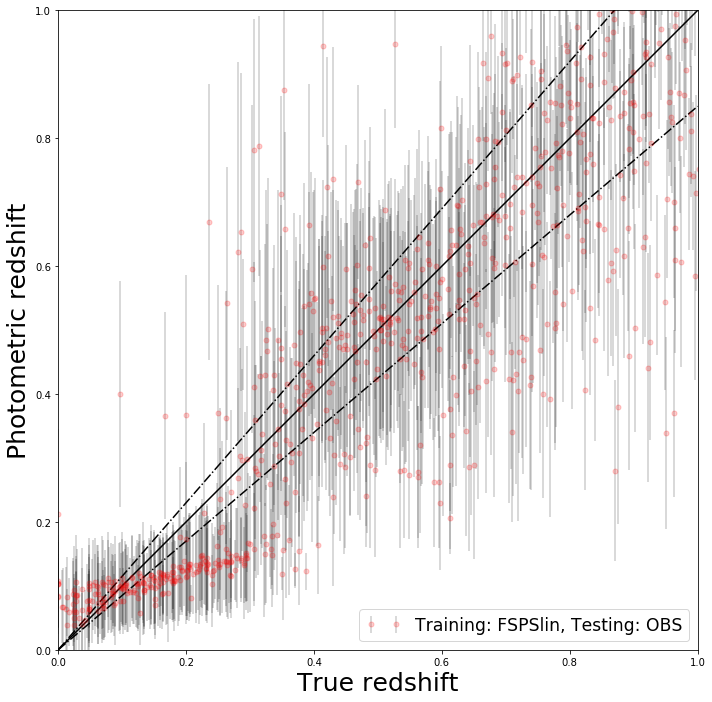

In [37]:
# fig = plt.figure(22)

ifPlotWeighted = True
# y_pred_mean_best = y_pred_mean[:, 0]
y_pred_mean_best = y_pred_mode[:, 0]
y_pred_std_best = y_pred_std[:, 0]


if ifPlotWeighted:
    plt.figure(22, figsize=(10, 10,))


    # # plt.scatter(y_test, y_pred, facecolors='k', s = 1)
#     plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
#       ymin + y_pred_std_new), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)
    
    plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred_mean_best), yerr= (ymax - ymin)*(
      ymin + y_pred_std_best), fmt='ro', ecolor='k', ms = 5, alpha = 0.2, label = 'Training: '+Trainset + ', Testing: '+Testset)

#     plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
#       ymin + y_pred_std), fmt='wo', ecolor='w', ms = 5, alpha = 0.8, label = 'Training with synthetic data')




plt.plot([0, 1], [0, 1], 'k')
plt.plot([0, 1], 0.85*np.array([0, 1]), 'k-.')
plt.plot([0, 1], 1.15*np.array([0, 1]), 'k-.')




plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)


plt.tight_layout()

plt.axes().set_aspect('equal')


leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.savefig('phoz_compare.pdf', bbox_inches='tight')

plt.show()


In [38]:
import scipy.stats
# hist = np.histogram(scaler.inverse_transform(Y_train), 64)
nbins = 40

# y_train_log = np.log(y_train)
hist = np.histogram(y_train, nbins)
prior = scipy.stats.rv_histogram(hist)

import pandas as pd
from scipy import stats 
s = pd.Series(hist[0])
prior2 = stats.gaussian_kde(s)

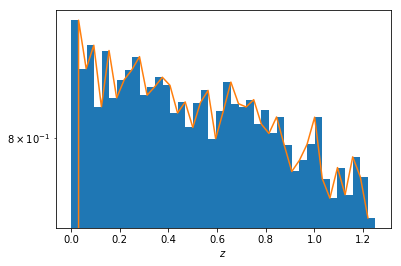

In [39]:
# plt.hist(scaler.inverse_transform(Y_train), 100, normed=True);
plt.hist(y_train, nbins, normed=True)
x = np.linspace(y_test.min(), y_test.max(), nbins)
# x = np.linspace(0.05, 0.1, nbins)

# x = np.logspace(np.log10(y_test.min()), np.log10(y_test.max()), nbins)
plt.plot(x, prior.pdf(x))
plt.yscale('log')
plt.xlabel(r'$z$')
plt.show()

In [40]:
# This returns the distribution q(M | x) for all clusters
outputs = model(X_test)
# outputs = model(X_train)
# xt = scaler.transform(x.reshape((-1,1)))
xt = x
logps = []

for i in np.arange(len(x)):
      logps.append(outputs.log_prob(xt[i]).numpy())

logps = np.array(logps)

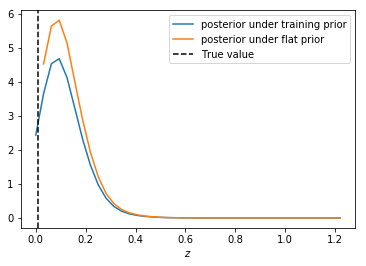

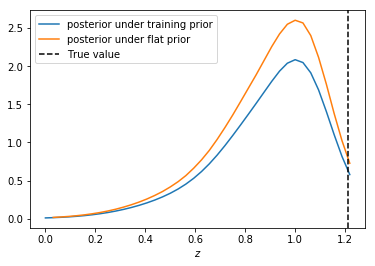

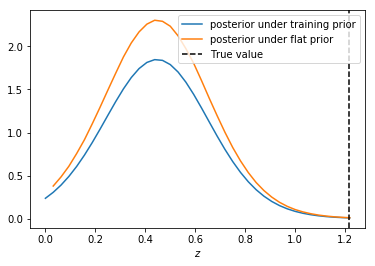

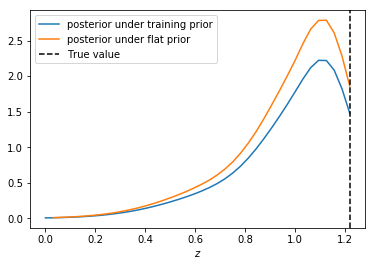

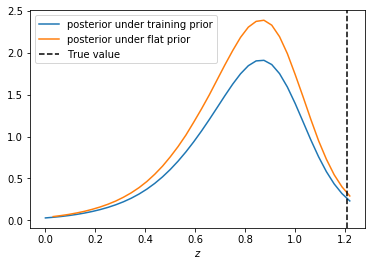

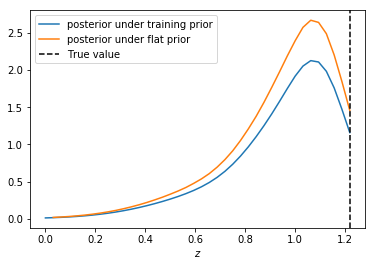

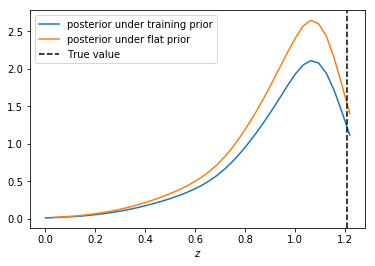

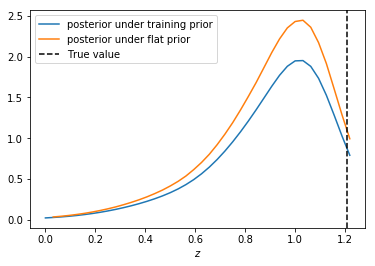

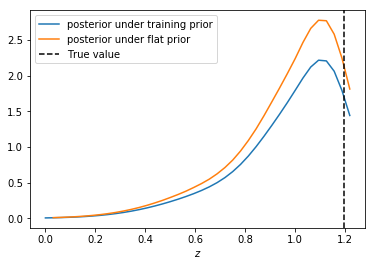

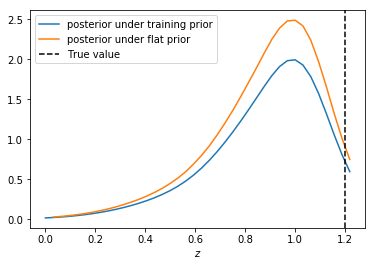

In [41]:
for i in np.arange(10):
  plt.figure()
  plt.plot(x, np.exp(logps[:,-i]), label='posterior under training prior')
  plt.plot(x, np.exp(logps[:,-i])/prior.pdf(x), label='posterior under flat prior')
  plt.axvline(y_test[-i], color='k', linestyle = 'dashed', label='True value')
  # plt.axvline(y_train[-i], color='k', linestyle = 'dashed', label='True value')
  # plt.xscale('log')
  plt.xlabel(r'$z$')
  plt.legend()

In [42]:
from scipy.integrate import simps
corrected_posterior = np.exp(logps)/(prior.pdf(x).reshape((-1,1)))

In [43]:
y_pred_prior_mean = simps(x.reshape((-1,1))*corrected_posterior,x,axis=0)/simps(corrected_posterior,x,axis=0)

In [44]:
y_pred_prior_mean.shape

(913,)

In [45]:
prior.pdf(x).min()

0.0

In [46]:
corrected_posterior.shape

(40, 913)

In [47]:
corrected_posterior[~np.isfinite(corrected_posterior )]

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, in

In [48]:
#### CHECK THIS ####

corrected_posterior[~np.isfinite(corrected_posterior )] = 0.0

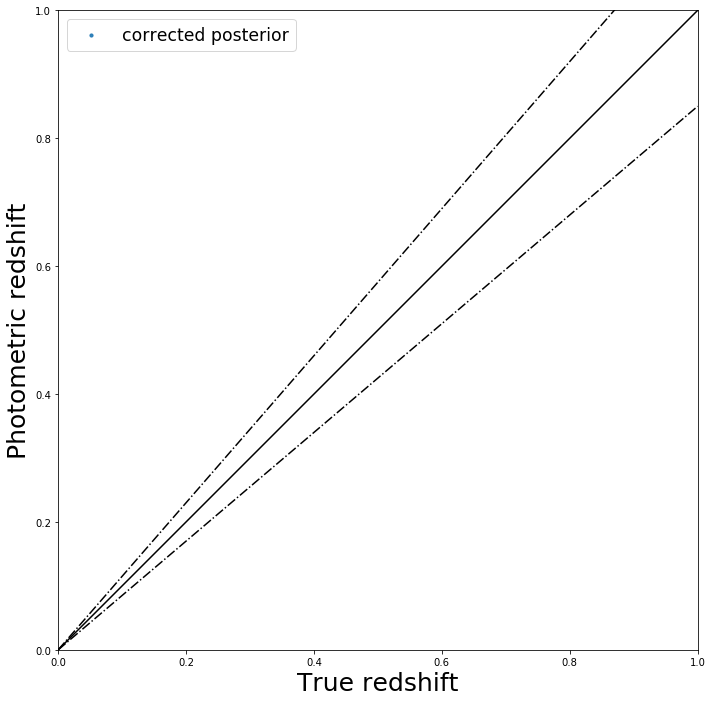

In [49]:
plt.figure(22, figsize=(10, 10,))


# plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred_prior_mean), yerr= (ymax - ymin)*(ymin + y_pred_std_best), fmt='ro', ecolor='r', ms = 5, alpha = 0.3, label = 'Training with synthetic data')

plt.scatter((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred_prior_mean), s = 10, alpha = 0.9, label = 'corrected posterior')


plt.xlim(0, 1)
plt.ylim(0, 1)

plt.plot([0, 1], [0, 1], 'k')
plt.plot([0, 1], 0.85*np.array([0, 1]), 'k-.')
plt.plot([0, 1], 1.15*np.array([0, 1]), 'k-.')

plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)

plt.tight_layout()

plt.axes().set_aspect('equal')


leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

# for artist, text in zip(leg.legendHandles, leg.get_texts()):
#     col = artist.get_color()
#     if isinstance(col, np.ndarray):
#         col = col[0]
#     text.set_color(col)
#     text.set_alpha(1.0)


plt.savefig('phoz_compare1.pdf', bbox_inches='tight')

plt.show()


In [50]:
def binned_plot(X, Y, n=10, percentiles=[35, 50], ax=None, **kwargs):
    # Calculation
    calc_percent = []
    for p in percentiles:
        if p < 50:
            calc_percent.append(50-p)
            calc_percent.append(50+p)
        elif p == 50:
            calc_percent.append(50)
        else:
            raise Exception('Percentile > 50')

    bin_edges = np.linspace(X.min()*0.9999, X.max()*1.0001, n+1)

    dtype = [(str(i), 'f') for i in calc_percent]
    bin_data = np.zeros(shape=(n,), dtype=dtype)

    for i in range(n):
        y = Y[(X >= bin_edges[i]) & (X < bin_edges[i+1])]

        if len(y) == 0:
            continue

        y_p = np.percentile(y, calc_percent)

        bin_data[i] = tuple(y_p)

    # Plotting
    if ax is None:
        f, ax = plt.subplots()

    bin_centers = [np.mean(bin_edges[i:i+2]) for i in range(n)]
    for p in percentiles:
        if p == 50:
            ax.plot(bin_centers, bin_data[str(p)], **kwargs)
        else:
            ax.fill_between(bin_centers,
                            bin_data[str(50-p)],
                            bin_data[str(50+p)],
                            alpha=0.2,
                            **kwargs)

    return bin_data, bin_edges

Text(0,0.5,'$\\epsilon$')

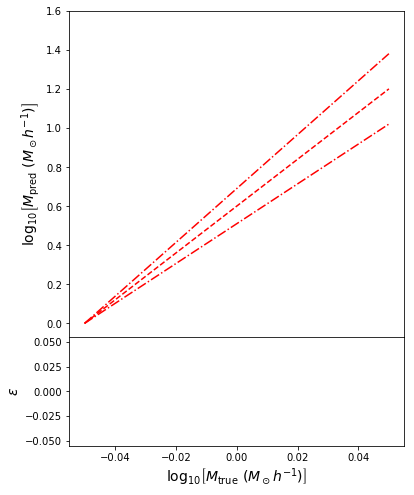

In [51]:
# replace y_true by y_test

import matplotlib as mpl
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])

ax1.plot(np.arange(y_test.min(),y_test.max(),0.1),np.arange(y_test.min(),y_test.max(),0.1),'r--')
ax1.plot(np.arange(y_test.min(),y_test.max(),0.1), 0.85*np.arange(y_test.min(),y_test.max(),0.1), 'r-.')
ax1.plot(np.arange(y_test.min(),y_test.max(),0.1), 1.15*np.arange(y_test.min(),y_test.max(),0.1), 'r-.')

# ax1.plot(np.arange(13,16,0.1),np.arange(13,16,0.1),'k--')
_ = binned_plot(y_test, 
                y_pred_prior_mean, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax1)

# ax1.set_xlim(0, 1)
# ax1.set_ylim(0, 1)
ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_ylabel(r'$\log_{10}\left[M_\mathrm{pred}\ (M_\odot h^{-1})\right]$', fontsize=14)


ax2 = f.add_subplot(gs[1,0])

# ax2.plot(np.arange(13.,16,0.1),[0]*30,'k--')
_ = binned_plot(y_test, 
                y_pred_prior_mean - y_test, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax2)

# ax2.set_xlim(0, 1)
# ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel(r'$\log_{10}\left[M_\mathrm{true}\ (M_\odot h^{-1})\right]$', fontsize=14)
ax2.set_ylabel(r'$\epsilon$', fontsize=14)

In [52]:
m = y_test < ymin
plt.plot(x, corrected_posterior[:,m][:,0])
plt.axvline(y_test[m][0], ls='--', label='true value', color='m')
plt.axvline(y_pred_prior_mean[m][0], label='posterior mean', color='r')
plt.legend()

IndexError: index 0 is out of bounds for axis 1 with size 0

In [53]:
y_pred_mode = x[np.exp(corrected_posterior).argmax(axis=0)]


Text(0,0.5,'$\\epsilon$')

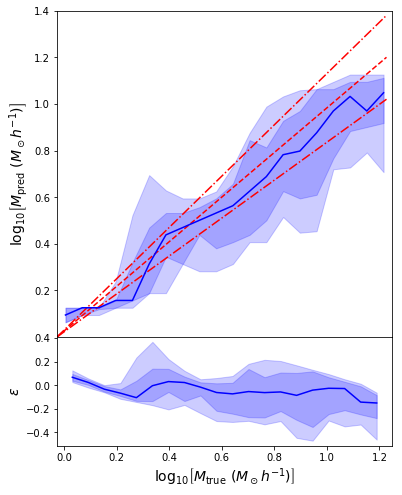

In [54]:
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])

ax1.plot(np.arange(y_test.min(),y_test.max(),0.1),np.arange(y_test.min(),y_test.max(),0.1),'r--')
ax1.plot(np.arange(y_test.min(),y_test.max(),0.1), 0.85*np.arange(y_test.min(),y_test.max(),0.1), 'r-.')
ax1.plot(np.arange(y_test.min(),y_test.max(),0.1), 1.15*np.arange(y_test.min(),y_test.max(),0.1), 'r-.')

_ = binned_plot(y_test, 
                y_pred_mode, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax1)

ax1.set_xlim(y_test.min(),y_test.max())
ax1.set_ylim(y_test.min(),y_test.max())
ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_ylabel(r'$\log_{10}\left[M_\mathrm{pred}\ (M_\odot h^{-1})\right]$', fontsize=14)

ax2 = f.add_subplot(gs[1,0])

# ax2.plot(np.arange(13,16,0.1),[0]*30,'k--')
_ = binned_plot(y_test, 
                y_pred_mode - y_test, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax2)
# ax2.set_xlim(13.5,15.3)
# ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel(r'$\log_{10}\left[M_\mathrm{true}\ (M_\odot h^{-1})\right]$', fontsize=14)
ax2.set_ylabel(r'$\epsilon$', fontsize=14)

In [55]:
y_pred_mode.shape

(913,)